## 1. Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [4]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256


img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
])



In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./Data/style_img2.jpg")
content_img = image_loader("./Data/content_img.jpg")

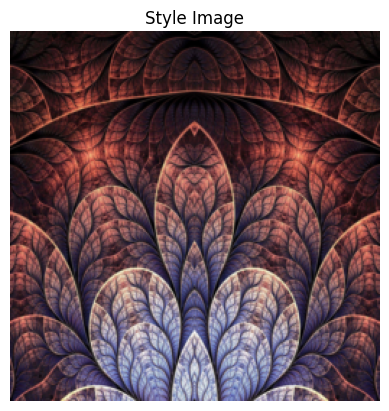

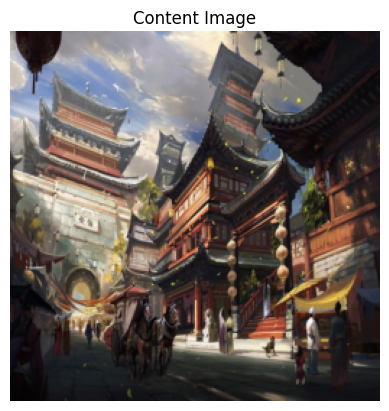

In [6]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1 Content Loss

In [7]:
content_weight = 1.0
ContentLoss = nn.MSELoss()

### 3.2 Style Loss

In [8]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    tensor = tensor.view(a * b, c * d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

## 3. Model

In [9]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8908\1740699474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8908\1740699474.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [11]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [12]:
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '16': 'conv_3',
        '25': 'conv_4',
        '34': 'conv_5'
    }
    features = {}
    x = image
    x = normalization(x)
    for name, pretrained_layer in pretrained_model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [13]:
def rot_style_features(style_features, style_layers):
    final_rot_style_features = {}
    for layer in style_layers:
        sf = style_features[layer].clone()
        rot90 = torch.rot90(sf.clone(), 1, (2, 3))
        rot180 = torch.rot90(rot90.clone(), 1, (2, 3))
        final_rot = sf + (rot90 - rot180)
        final_rot_style_features[layer] = final_rot
    return final_rot_style_features

In [14]:
content_features = get_features(VGG19_pretrained, content_img)
style_features1 = get_features(VGG19_pretrained, style_img)
final_rot_style_features = rot_style_features(style_features1, style_layers)

## 4. Training

In [ ]:
import torch.optim as optim

target_img1 = content_img.clone().requires_grad_(True).to(device)
target_img2 = content_img.clone().requires_grad_(True).to(device)
optimizer1 = optim.Adam([target_img1], lr=0.02)
optimizer2 = optim.Adam([target_img2], lr=0.02)

In [16]:
def style_tranfer_(model, optimizer, target_img,
                   content_features, style_features,
                   style_layers, content_weight, style_weight):

    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)
    target_features = get_features(model, target_img)

    content_loss = ContentLoss(content_features['conv_4'], target_features['conv_4'])

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += StyleLoss(style_gram, target_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, content_loss, style_loss

In [17]:
STEPS = 500

for step in range(STEPS):

    total_loss1, content_loss1, style_loss1 = style_tranfer_(VGG19_pretrained, optimizer1, target_img1,
                                                           content_features, style_features1,
                                                           style_layers, content_weight, style_weight)

    total_loss2, content_loss2, style_loss2 = style_tranfer_(VGG19_pretrained, optimizer2, target_img2,
                                                           content_features, final_rot_style_features,
                                                           style_layers, content_weight, style_weight)

    if step % 100 == 99:
        print(f"Epoch [{step+1}/{STEPS}] Total loss1: {total_loss1.item():.6f} - \
                Content loss1: {content_loss1.item():.6f} - Style loss1: {style_loss1.item():.6f}")
        print(f"Epoch [{step+1}/{STEPS}] Total loss2: {total_loss2.item():.6f} - \
                Content loss1: {content_loss2.item():.6f} - Style loss2: {style_loss2.item():.6f}")

    with torch.no_grad():
        target_img1.clamp_(0, 1)
        target_img2.clamp_(0, 1)

Epoch [100/500] Total loss1: 7.746951 -                 Content loss1: 4.815155 - Style loss1: 0.000003
Epoch [100/500] Total loss2: 235.377670 -                 Content loss1: 9.025440 - Style loss2: 0.000226
Epoch [200/500] Total loss1: 6.896716 -                 Content loss1: 4.431968 - Style loss1: 0.000002
Epoch [200/500] Total loss2: 214.432678 -                 Content loss1: 9.071190 - Style loss2: 0.000205
Epoch [300/500] Total loss1: 5.954077 -                 Content loss1: 4.150463 - Style loss1: 0.000002
Epoch [300/500] Total loss2: 206.062958 -                 Content loss1: 9.082542 - Style loss2: 0.000197
Epoch [400/500] Total loss1: 5.762444 -                 Content loss1: 4.017466 - Style loss1: 0.000002
Epoch [400/500] Total loss2: 201.845032 -                 Content loss1: 9.026163 - Style loss2: 0.000193
Epoch [500/500] Total loss1: 5.635421 -                 Content loss1: 3.939846 - Style loss1: 0.000002
Epoch [500/500] Total loss2: 199.000626 -               

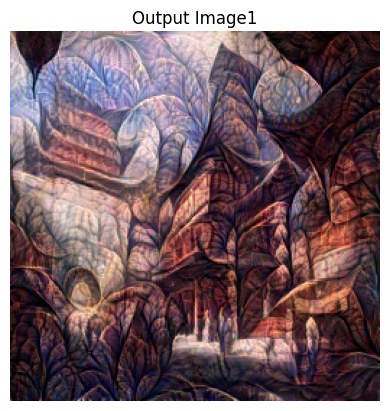

In [18]:
plt.figure()
plt.axis('off')

imshow(target_img1.detach(), title='Output Image1')
plt.show()

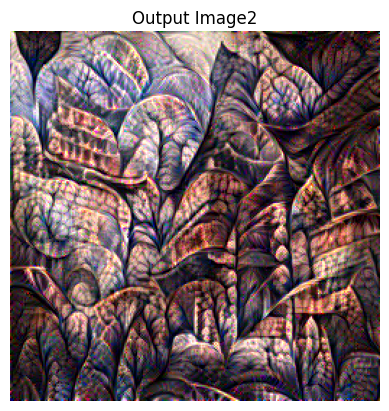

In [19]:
plt.figure()
plt.axis('off')

imshow(target_img2.detach(), title='Output Image2')
plt.show()